In [48]:
from RBFNN import RBFNN, ModelType
from dataset.chaotic_system import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from utils import *
import copy
import os
import time


class Dict(dict):
    __setattr__ = dict.__setitem__
    __getattr__ = dict.__getitem__


names = [
    'rossler',
    'rabinovich_fabrikant',
    'lorentz',
    'chua',
]
names = [n + '1d' for n in names]

n_dim = 1

N = 10000
n_history = 10
N_h = 200
num_prepare = 0
num_train = 2000
num_test = 2000
train_start = 0
test_start = 5000
np.random.seed()
nz = 100
connectivity = 1
reservoirConf = Dict(
    alpha=0.9,
    connectivity= connectivity,
    nz= nz,
    nu = n_dim,
    target_rho=0.99,
    input_scale= 1
)

path = 'result/direct_multistep_prediction'
if not os.path.exists(path):
    os.makedirs(path)


def gen_model(conf):
    _, model_type, kwargs = conf
    conf_dict = dict(
        model_type=model_type,
        **kwargs
    )
    return RBFNN(**conf_dict)


def select_model(model_confs):
    MSE = [0.0] * len(model_confs)
    for j, conf in enumerate(model_confs):
        model = gen_model(conf)
        model.train(x_train, y_train, num_prepare)
        Predictions = model.predict(x_test, num_prepare)
        MSE[j] = mse(Predictions, y_test)
    best_model = model_confs[np.argmin(MSE)]
    return best_model
    
    
for file in range(1,10):
    result_file = path + '/result_'+str(file) + '.csv'
    if os.path.exists(result_file):
        result = pd.read_csv(result_file)
    else:
        result = pd.DataFrame(columns=['datetime', 'system_name',  'n_dim', 'n_history', 'horizon', 'model_name', 'N_h', 'sigma','reservoir_encoder','nz', 'connectivity', 'mse'])

    process_start_time = time.time()
    print('开始数据处理')
    for system_name in names:
        for horizon in range(1,11):
        
            '''
            数据集
            '''
            x = np.loadtxt('dataset/'+system_name+'.txt', delimiter=',').T
            x += np.random.randn(*x.shape)*0.001

            x_train = np.vstack([select_samples(x, train_start + i, num_train + num_prepare) for i in range(n_history)])
            y_train = select_samples(x, train_start + num_prepare + n_history + horizon - 1, num_train)
            x_test  = np.vstack([select_samples(x, test_start + i, num_test + num_prepare) for i in range(n_history)])
            y_test  = select_samples(x, test_start + num_prepare + n_history + horizon - 1, num_test) 


            rc = reservoirConf


            '''
            单步预测
            '''
            model_confs = []
            model_confs.append(
                [('ESN-trannsform', 
                ModelType.ESN, 
                dict(reservoirConf=rc,encoder='transform'))]
            )

            model_confs.append(
                [('RBFLN-RE-transform', 
                ModelType.RBFLN_RE, 
                dict(N_h=N_h, sigma=sigma, reservoirConf=rc, encoder='transform')) 
                for sigma in [ 1 / 8, 1 / 4, 1 / 2, 1, 2, 4, 8]]
            )
            
            model_confs.append(
                [('ESN-ATTN-transform',
                ModelType.ESN_ATTN, 
                dict(N_h=N_h, sigma=sigma, reservoirConf=rc,encoder='transform'))
                for sigma in [ 1 / 8, 1 / 4, 1 / 2, 1, 2, 4, 8]]
            )
            
#             model_confs += [('RBFLN',ModelType.RBFLN, dict(N_h=N_h, sigma=sigma))
#                             for sigma in [ 1 / 8, 1 / 4, 1 / 2, 1, 2, 4, 8]]
#             model_confs += [('RBFN',ModelType.RBFN, dict(N_h=N_h, sigma=sigma))
#                             for sigma in [ 1 / 8, 1 / 4, 1 / 2, 1, 2, 4, 8]]
#             model_confs += [('VAR',ModelType.VAR, dict())]


            colors = list(cnames.keys())


            for j, confs in enumerate(model_confs):
            
                conf = select_model(confs)
                
                model_name, model_type, kwargs = conf
                
                conf_dict = dict(
                    model_type=model_type,
                    **kwargs
                )

                model = RBFNN(**conf_dict)
                model.train(x_train, y_train, num_prepare)
                pred = model.predict(x_test, num_prepare)

                MSE = mse(pred, y_test)

                result.loc[result.shape[0]] = {
                    'datetime'          : pd.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                    'system_name'       : system_name,
                    'n_dim'             : n_dim,
                    'n_history'         : n_history,
                    'horizon'           : horizon,
                    'model_name'        : model_name,
                    'N_h'               : N_h,
                    'sigma'             : kwargs.get('sigma', 0),
                    'nz'                : nz,
                    'connectivity'      : connectivity,
                    'reservoir_encoder' : 0 if rc is None else 1,
                    'mse'               : MSE
                }
                print(result.loc[result.shape[0]-1][['system_name', 'model_name', 'horizon','mse']])

                


    result.to_csv(result_file, index=False)

    print('结束数据处理')
    process_stop_time = time.time()

    # 差的时间戳
    diff_time = process_stop_time - process_start_time
    # 将计算出来的时间戳转换为结构化时间
    struct_time = time.gmtime(diff_time)
    # 减去时间戳最开始的时间 并格式化输出
    print('数据处理用了{0}年{1}月{2}日{3}小时{4}分钟{5}秒'.format(
        struct_time.tm_year - 1970,
        struct_time.tm_mon - 1,
        struct_time.tm_mday - 1,
        struct_time.tm_hour,
        struct_time.tm_min,
        struct_time.tm_sec
    ))

开始数据处理
system_name         rossler1d
model_name     ESN-trannsform
horizon                     1
mse               5.23236e-06
Name: 0, dtype: object
system_name             rossler1d
model_name     RBFLN-RE-transform
horizon                         1
mse                   4.13971e-06
Name: 1, dtype: object
system_name             rossler1d
model_name     ESN-ATTN-transform
horizon                         1
mse                   4.46491e-06
Name: 2, dtype: object
system_name         rossler1d
model_name     ESN-trannsform
horizon                     2
mse               3.83063e-05
Name: 3, dtype: object
system_name             rossler1d
model_name     RBFLN-RE-transform
horizon                         2
mse                   1.00251e-05
Name: 4, dtype: object
system_name             rossler1d
model_name     ESN-ATTN-transform
horizon                         2
mse                   1.74979e-05
Name: 5, dtype: object
system_name         rossler1d
model_name     ESN-trannsform
horizon    

system_name    rabinovich_fabrikant1d
model_name             ESN-trannsform
horizon                             8
mse                       0.000232718
Name: 51, dtype: object
system_name    rabinovich_fabrikant1d
model_name         RBFLN-RE-transform
horizon                             8
mse                       0.000180615
Name: 52, dtype: object
system_name    rabinovich_fabrikant1d
model_name         ESN-ATTN-transform
horizon                             8
mse                       0.000240046
Name: 53, dtype: object
system_name    rabinovich_fabrikant1d
model_name             ESN-trannsform
horizon                             9
mse                       0.000303156
Name: 54, dtype: object
system_name    rabinovich_fabrikant1d
model_name         RBFLN-RE-transform
horizon                             9
mse                       0.000125273
Name: 55, dtype: object
system_name    rabinovich_fabrikant1d
model_name         ESN-ATTN-transform
horizon                             9
mse   

system_name                chua1d
model_name     RBFLN-RE-transform
horizon                         5
mse                    0.00273622
Name: 103, dtype: object
system_name                chua1d
model_name     ESN-ATTN-transform
horizon                         5
mse                    0.00252755
Name: 104, dtype: object
system_name            chua1d
model_name     ESN-trannsform
horizon                     6
mse                 0.0038709
Name: 105, dtype: object
system_name                chua1d
model_name     RBFLN-RE-transform
horizon                         6
mse                    0.00351242
Name: 106, dtype: object
system_name                chua1d
model_name     ESN-ATTN-transform
horizon                         6
mse                    0.00367934
Name: 107, dtype: object
system_name            chua1d
model_name     ESN-trannsform
horizon                     7
mse                0.00475505
Name: 108, dtype: object
system_name                chua1d
model_name     RBFLN-RE-transfor

system_name    rabinovich_fabrikant1d
model_name         ESN-ATTN-transform
horizon                             2
mse                        9.5687e-06
Name: 35, dtype: object
system_name    rabinovich_fabrikant1d
model_name             ESN-trannsform
horizon                             3
mse                       3.51608e-05
Name: 36, dtype: object
system_name    rabinovich_fabrikant1d
model_name         RBFLN-RE-transform
horizon                             3
mse                       2.88728e-05
Name: 37, dtype: object
system_name    rabinovich_fabrikant1d
model_name         ESN-ATTN-transform
horizon                             3
mse                       2.29993e-05
Name: 38, dtype: object
system_name    rabinovich_fabrikant1d
model_name             ESN-trannsform
horizon                             4
mse                       5.35309e-05
Name: 39, dtype: object
system_name    rabinovich_fabrikant1d
model_name         RBFLN-RE-transform
horizon                             4
mse   

system_name             lorentz1d
model_name     RBFLN-RE-transform
horizon                         9
mse                    0.00636747
Name: 85, dtype: object
system_name             lorentz1d
model_name     ESN-ATTN-transform
horizon                         9
mse                     0.0094046
Name: 86, dtype: object
system_name         lorentz1d
model_name     ESN-trannsform
horizon                    10
mse                 0.0118595
Name: 87, dtype: object
system_name             lorentz1d
model_name     RBFLN-RE-transform
horizon                        10
mse                    0.00615713
Name: 88, dtype: object
system_name             lorentz1d
model_name     ESN-ATTN-transform
horizon                        10
mse                     0.0102194
Name: 89, dtype: object
system_name            chua1d
model_name     ESN-trannsform
horizon                     1
mse               2.30944e-05
Name: 90, dtype: object
system_name                chua1d
model_name     RBFLN-RE-transform
hori

system_name         rossler1d
model_name     ESN-trannsform
horizon                     7
mse                0.00142222
Name: 18, dtype: object
system_name             rossler1d
model_name     RBFLN-RE-transform
horizon                         7
mse                   0.000160055
Name: 19, dtype: object
system_name             rossler1d
model_name     ESN-ATTN-transform
horizon                         7
mse                   0.000750333
Name: 20, dtype: object
system_name         rossler1d
model_name     ESN-trannsform
horizon                     8
mse                0.00174149
Name: 21, dtype: object
system_name             rossler1d
model_name     RBFLN-RE-transform
horizon                         8
mse                    0.00026516
Name: 22, dtype: object
system_name             rossler1d
model_name     ESN-ATTN-transform
horizon                         8
mse                   0.000879032
Name: 23, dtype: object
system_name         rossler1d
model_name     ESN-trannsform
horizon     

system_name             lorentz1d
model_name     RBFLN-RE-transform
horizon                         3
mse                   0.000111492
Name: 67, dtype: object
system_name             lorentz1d
model_name     ESN-ATTN-transform
horizon                         3
mse                   0.000491927
Name: 68, dtype: object
system_name         lorentz1d
model_name     ESN-trannsform
horizon                     4
mse                0.00319171
Name: 69, dtype: object
system_name             lorentz1d
model_name     RBFLN-RE-transform
horizon                         4
mse                   0.000246113
Name: 70, dtype: object
system_name             lorentz1d
model_name     ESN-ATTN-transform
horizon                         4
mse                    0.00134773
Name: 71, dtype: object
system_name         lorentz1d
model_name     ESN-trannsform
horizon                     5
mse                0.00623013
Name: 72, dtype: object
system_name             lorentz1d
model_name     RBFLN-RE-transform
hori

system_name         rossler1d
model_name     ESN-trannsform
horizon                     1
mse               5.15485e-06
Name: 0, dtype: object
system_name             rossler1d
model_name     RBFLN-RE-transform
horizon                         1
mse                   3.91475e-06
Name: 1, dtype: object
system_name             rossler1d
model_name     ESN-ATTN-transform
horizon                         1
mse                   4.45595e-06
Name: 2, dtype: object
system_name         rossler1d
model_name     ESN-trannsform
horizon                     2
mse               3.39291e-05
Name: 3, dtype: object
system_name             rossler1d
model_name     RBFLN-RE-transform
horizon                         2
mse                   9.62241e-06
Name: 4, dtype: object
system_name             rossler1d
model_name     ESN-ATTN-transform
horizon                         2
mse                   1.58179e-05
Name: 5, dtype: object
system_name         rossler1d
model_name     ESN-trannsform
horizon           

system_name    rabinovich_fabrikant1d
model_name             ESN-trannsform
horizon                             8
mse                       0.000318348
Name: 51, dtype: object
system_name    rabinovich_fabrikant1d
model_name         RBFLN-RE-transform
horizon                             8
mse                        0.00013435
Name: 52, dtype: object
system_name    rabinovich_fabrikant1d
model_name         ESN-ATTN-transform
horizon                             8
mse                       0.000259649
Name: 53, dtype: object
system_name    rabinovich_fabrikant1d
model_name             ESN-trannsform
horizon                             9
mse                       0.000376663
Name: 54, dtype: object
system_name    rabinovich_fabrikant1d
model_name         RBFLN-RE-transform
horizon                             9
mse                       0.000189135
Name: 55, dtype: object
system_name    rabinovich_fabrikant1d
model_name         ESN-ATTN-transform
horizon                             9
mse   

system_name                chua1d
model_name     RBFLN-RE-transform
horizon                         5
mse                    0.00256559
Name: 103, dtype: object
system_name                chua1d
model_name     ESN-ATTN-transform
horizon                         5
mse                    0.00256391
Name: 104, dtype: object
system_name            chua1d
model_name     ESN-trannsform
horizon                     6
mse                0.00375735
Name: 105, dtype: object
system_name                chua1d
model_name     RBFLN-RE-transform
horizon                         6
mse                    0.00416974
Name: 106, dtype: object
system_name                chua1d
model_name     ESN-ATTN-transform
horizon                         6
mse                    0.00378554
Name: 107, dtype: object
system_name            chua1d
model_name     ESN-trannsform
horizon                     7
mse                0.00468452
Name: 108, dtype: object
system_name                chua1d
model_name     RBFLN-RE-transfor

system_name    rabinovich_fabrikant1d
model_name         ESN-ATTN-transform
horizon                             2
mse                       9.97928e-06
Name: 35, dtype: object
system_name    rabinovich_fabrikant1d
model_name             ESN-trannsform
horizon                             3
mse                       2.71192e-05
Name: 36, dtype: object
system_name    rabinovich_fabrikant1d
model_name         RBFLN-RE-transform
horizon                             3
mse                       2.16142e-05
Name: 37, dtype: object
system_name    rabinovich_fabrikant1d
model_name         ESN-ATTN-transform
horizon                             3
mse                       2.41665e-05
Name: 38, dtype: object
system_name    rabinovich_fabrikant1d
model_name             ESN-trannsform
horizon                             4
mse                       4.62159e-05
Name: 39, dtype: object
system_name    rabinovich_fabrikant1d
model_name         RBFLN-RE-transform
horizon                             4
mse   

system_name             lorentz1d
model_name     RBFLN-RE-transform
horizon                         9
mse                    0.00660686
Name: 85, dtype: object
system_name             lorentz1d
model_name     ESN-ATTN-transform
horizon                         9
mse                      0.010133
Name: 86, dtype: object
system_name         lorentz1d
model_name     ESN-trannsform
horizon                    10
mse                 0.0109339
Name: 87, dtype: object
system_name             lorentz1d
model_name     RBFLN-RE-transform
horizon                        10
mse                    0.00609528
Name: 88, dtype: object
system_name             lorentz1d
model_name     ESN-ATTN-transform
horizon                        10
mse                     0.0100849
Name: 89, dtype: object
system_name            chua1d
model_name     ESN-trannsform
horizon                     1
mse               2.43716e-05
Name: 90, dtype: object
system_name                chua1d
model_name     RBFLN-RE-transform
hori

system_name         rossler1d
model_name     ESN-trannsform
horizon                     7
mse                0.00101861
Name: 18, dtype: object
system_name             rossler1d
model_name     RBFLN-RE-transform
horizon                         7
mse                   0.000271144
Name: 19, dtype: object
system_name             rossler1d
model_name     ESN-ATTN-transform
horizon                         7
mse                    0.00104183
Name: 20, dtype: object
system_name         rossler1d
model_name     ESN-trannsform
horizon                     8
mse                0.00105613
Name: 21, dtype: object
system_name             rossler1d
model_name     RBFLN-RE-transform
horizon                         8
mse                   0.000209676
Name: 22, dtype: object
system_name             rossler1d
model_name     ESN-ATTN-transform
horizon                         8
mse                    0.00127077
Name: 23, dtype: object
system_name         rossler1d
model_name     ESN-trannsform
horizon     

system_name             lorentz1d
model_name     RBFLN-RE-transform
horizon                         3
mse                   9.04775e-05
Name: 67, dtype: object
system_name             lorentz1d
model_name     ESN-ATTN-transform
horizon                         3
mse                   0.000350014
Name: 68, dtype: object
system_name         lorentz1d
model_name     ESN-trannsform
horizon                     4
mse                0.00315801
Name: 69, dtype: object
system_name             lorentz1d
model_name     RBFLN-RE-transform
horizon                         4
mse                   0.000202484
Name: 70, dtype: object
system_name             lorentz1d
model_name     ESN-ATTN-transform
horizon                         4
mse                    0.00163614
Name: 71, dtype: object
system_name         lorentz1d
model_name     ESN-trannsform
horizon                     5
mse                0.00565164
Name: 72, dtype: object
system_name             lorentz1d
model_name     RBFLN-RE-transform
hori

system_name         rossler1d
model_name     ESN-trannsform
horizon                     1
mse               5.82822e-06
Name: 0, dtype: object
system_name             rossler1d
model_name     RBFLN-RE-transform
horizon                         1
mse                   3.57032e-06
Name: 1, dtype: object
system_name             rossler1d
model_name     ESN-ATTN-transform
horizon                         1
mse                    3.8653e-06
Name: 2, dtype: object
system_name         rossler1d
model_name     ESN-trannsform
horizon                     2
mse               2.85368e-05
Name: 3, dtype: object
system_name             rossler1d
model_name     RBFLN-RE-transform
horizon                         2
mse                   9.32656e-06
Name: 4, dtype: object
system_name             rossler1d
model_name     ESN-ATTN-transform
horizon                         2
mse                    1.4277e-05
Name: 5, dtype: object
system_name         rossler1d
model_name     ESN-trannsform
horizon           

system_name    rabinovich_fabrikant1d
model_name             ESN-trannsform
horizon                             8
mse                       0.000195262
Name: 51, dtype: object
system_name    rabinovich_fabrikant1d
model_name         RBFLN-RE-transform
horizon                             8
mse                       0.000155066
Name: 52, dtype: object
system_name    rabinovich_fabrikant1d
model_name         ESN-ATTN-transform
horizon                             8
mse                       0.000220649
Name: 53, dtype: object
system_name    rabinovich_fabrikant1d
model_name             ESN-trannsform
horizon                             9
mse                       0.000350377
Name: 54, dtype: object
system_name    rabinovich_fabrikant1d
model_name         RBFLN-RE-transform
horizon                             9
mse                       0.000207212
Name: 55, dtype: object
system_name    rabinovich_fabrikant1d
model_name         ESN-ATTN-transform
horizon                             9
mse   

system_name                chua1d
model_name     RBFLN-RE-transform
horizon                         5
mse                    0.00262842
Name: 103, dtype: object
system_name                chua1d
model_name     ESN-ATTN-transform
horizon                         5
mse                    0.00248554
Name: 104, dtype: object
system_name            chua1d
model_name     ESN-trannsform
horizon                     6
mse                0.00367141
Name: 105, dtype: object
system_name                chua1d
model_name     RBFLN-RE-transform
horizon                         6
mse                    0.00365997
Name: 106, dtype: object
system_name                chua1d
model_name     ESN-ATTN-transform
horizon                         6
mse                    0.00363237
Name: 107, dtype: object
system_name            chua1d
model_name     ESN-trannsform
horizon                     7
mse                0.00444248
Name: 108, dtype: object
system_name                chua1d
model_name     RBFLN-RE-transfor

system_name    rabinovich_fabrikant1d
model_name         ESN-ATTN-transform
horizon                             2
mse                        1.0832e-05
Name: 35, dtype: object
system_name    rabinovich_fabrikant1d
model_name             ESN-trannsform
horizon                             3
mse                       2.40313e-05
Name: 36, dtype: object
system_name    rabinovich_fabrikant1d
model_name         RBFLN-RE-transform
horizon                             3
mse                       2.29319e-05
Name: 37, dtype: object
system_name    rabinovich_fabrikant1d
model_name         ESN-ATTN-transform
horizon                             3
mse                       2.41875e-05
Name: 38, dtype: object
system_name    rabinovich_fabrikant1d
model_name             ESN-trannsform
horizon                             4
mse                        5.2048e-05
Name: 39, dtype: object
system_name    rabinovich_fabrikant1d
model_name         RBFLN-RE-transform
horizon                             4
mse   

system_name             lorentz1d
model_name     RBFLN-RE-transform
horizon                         9
mse                    0.00655849
Name: 85, dtype: object
system_name             lorentz1d
model_name     ESN-ATTN-transform
horizon                         9
mse                    0.00963831
Name: 86, dtype: object
system_name         lorentz1d
model_name     ESN-trannsform
horizon                    10
mse                 0.0110265
Name: 87, dtype: object
system_name             lorentz1d
model_name     RBFLN-RE-transform
horizon                        10
mse                    0.00636715
Name: 88, dtype: object
system_name             lorentz1d
model_name     ESN-ATTN-transform
horizon                        10
mse                     0.0104171
Name: 89, dtype: object
system_name            chua1d
model_name     ESN-trannsform
horizon                     1
mse               2.35157e-05
Name: 90, dtype: object
system_name                chua1d
model_name     RBFLN-RE-transform
hori

system_name         rossler1d
model_name     ESN-trannsform
horizon                     7
mse                0.00105134
Name: 18, dtype: object
system_name             rossler1d
model_name     RBFLN-RE-transform
horizon                         7
mse                   0.000149873
Name: 19, dtype: object
system_name             rossler1d
model_name     ESN-ATTN-transform
horizon                         7
mse                   0.000841338
Name: 20, dtype: object
system_name         rossler1d
model_name     ESN-trannsform
horizon                     8
mse                0.00198035
Name: 21, dtype: object
system_name             rossler1d
model_name     RBFLN-RE-transform
horizon                         8
mse                    0.00016025
Name: 22, dtype: object
system_name             rossler1d
model_name     ESN-ATTN-transform
horizon                         8
mse                    0.00112249
Name: 23, dtype: object
system_name         rossler1d
model_name     ESN-trannsform
horizon     

system_name             lorentz1d
model_name     RBFLN-RE-transform
horizon                         3
mse                   0.000166105
Name: 67, dtype: object
system_name             lorentz1d
model_name     ESN-ATTN-transform
horizon                         3
mse                   0.000407551
Name: 68, dtype: object
system_name         lorentz1d
model_name     ESN-trannsform
horizon                     4
mse                0.00350264
Name: 69, dtype: object
system_name             lorentz1d
model_name     RBFLN-RE-transform
horizon                         4
mse                   0.000248459
Name: 70, dtype: object
system_name             lorentz1d
model_name     ESN-ATTN-transform
horizon                         4
mse                    0.00169755
Name: 71, dtype: object
system_name         lorentz1d
model_name     ESN-trannsform
horizon                     5
mse                0.00596321
Name: 72, dtype: object
system_name             lorentz1d
model_name     RBFLN-RE-transform
hori

# result analysis

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime


In [50]:
system_names = ['rossler','rabinovich_fabrikant','lorentz','chua']
system_names = [system + '1d' for system in system_names]

path = 'result/direct_multistep_prediction'
result_file0 = path + '/result_0.csv' 
df = pd.read_csv(result_file0, index_col = 'datetime')
df.index = pd.DatetimeIndex(df.index)

set(df['model_name'])

{'ESN-ATTN-transform', 'ESN-trannsform', 'RBFLN-RE-transform'}

rossler1d


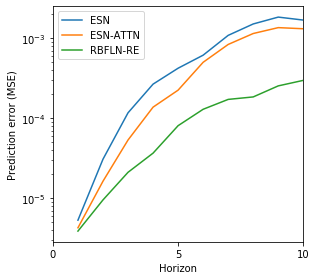

rabinovich_fabrikant1d


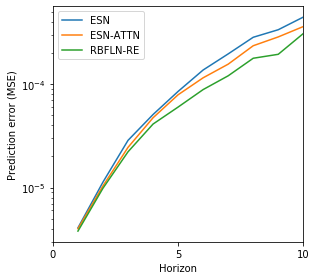

lorentz1d


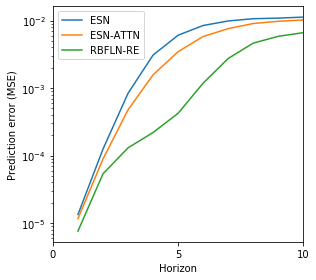

chua1d


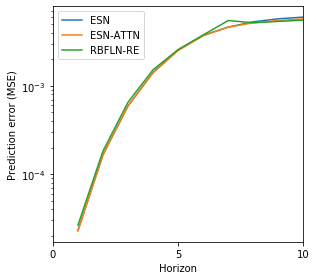

In [53]:
for system_name in system_names:
    print(system_name)

    model_names = [ 'ESN-trannsform', 'ESN-ATTN-transform','RBFLN-RE-transform']

    average = pd.DataFrame()
    for i in range(10):
        result_file = path +'/result_' +str(i) + '.csv' 
        df = pd.read_csv(result_file, index_col = 'datetime')
        df.index = pd.DatetimeIndex(df.index)

        result = df[df['system_name'].isin([system_name]) & 
                    df['model_name'].isin(model_names) & 
                    df['horizon'].isin(list(range(11)))]


        final = None
        for w in set(result['horizon']):
            temp = result.loc[result['horizon'] == w, ['model_name', 'mse', 'horizon']].groupby('model_name').min().reset_index()
            final = temp if final is None else final.append(temp, ignore_index=True)

        average = average.append(final,ignore_index=True)
        
    fig, ax = plt.subplots(figsize=(4.5,4))

    for name in model_names:
        average.loc[average['model_name'] == name].groupby('horizon').mean().sort_values(by='horizon').plot(ax = ax)

    plt.legend(labels= [ 'ESN', 'ESN-ATTN','RBFLN-RE'], loc='upper left')
    ax.set_yscale("log")
    # ax.set_xscale("log")
    plt.xlabel('Horizon')
    plt.ylabel('Prediction error (MSE)')
    plt.xticks([0,5,10])
    plt.tight_layout()

    plt.savefig(path + '/'+system_name+'_horizon.pdf')

    plt.show()